# Install and Load Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.power import TTestPower, TTestIndPower, GofChisquarePower
from statsmodels.stats.proportion import proportions_chisquare
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm

import scipy.stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Dataset

In [2]:
raw_data = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/marketing_campaign_experiment/marketing-clean.csv")

# Power Analysis

## One Mean t-Test

This test if a sample mean is any different from a set value for a normaly distributed variable.

**Example**

You are interested in determining if the average income of college freshman is less than 20,000 USD. You collect trial data and find that the mean income was 14,500 USD (SD=6000)


In [3]:
# initialize t-test power analysis object
analysis = TTestPower()

# mean of h0
mean_0 = 20000
# mean of h1
mean_1 = 14500
# std of h1
std = 6000

effect_size = (mean_1 - mean_0) / std

result = analysis.solve_power(
    effect_size, 
    power = 0.80, 
    alternative = "smaller",
    alpha = 0.05
)

In [4]:
# Calculate sample size
print('Sample Size: %.3f' % result)

Sample Size: 8.877


Based on the result, we need at least 9 samples

## Two Mean t-Test

This tests if a mean from one group is different from the mean of another group for a normally distributed variable.

**Example**

We have 1 million users. We assumes that their spending is normally distributed. Based on last 3 months historical data, we got mean spending is currently 5.25 USD and the standard deviation is equal to 1 USD. Let say, marketing team want to see a 0.50 USD change at minimum. The power of is around 0.9 and the significance around 0.01

In [5]:
# initialize t-test power analysis object
analysis = TTestIndPower()

result = analysis.solve_power(
    0.5, 
    power = 0.90, 
    alternative = "larger",
    alpha = 0.01
)

In [6]:
# Calculate sample size
print('Sample Size: %.3f' % result)

Sample Size: 105.500


From this analysis, we can conclude that at a minimum we need 106 participants in each group (control & experiment)

## Chi-Squared Test

Asks if table of observed values are any different from a table of expected ones. Also called Goodness-of-fit test.

**Example**

We want to observe conversion of new landing page based. We expect that there will be 5% improvement compared to the old one. Calculate the sample size.


In [7]:
# initialize t-test power analysis object
analysis = GofChisquarePower()

result = analysis.solve_power(
    0.05, 
    alpha = 0.05,
    power = 0.8,
    n_bins = 2
)

In [8]:
# Calculate sample size
print('Sample Size: %.3f' % result)

Sample Size: 3139.544


From this analysis, we can conclude that at a minimum we need 3140 participants in each group (control & experiment)

# A/B Testing

## Data Inspection and Exploration


Check null values inside data

In [9]:
raw_data.isna().sum()

user_id                0
date_served            0
marketing_channel      0
variant                0
converted              0
language_displayed     0
language_preferred     0
age_group              0
date_subscribed        0
date_canceled          0
subscribing_channel    0
is_retained            0
conversion             0
dtype: int64

In [10]:
raw_data.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,conversion
0,a100000040,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,1/18/18,House Ads,False,1
1,a100000041,1/1/18,House Ads,personalization,True,Arabic,Arabic,24-30 years,1/1/18,2/22/18,House Ads,False,1
2,a100000042,1/1/18,House Ads,personalization,True,English,English,0-18 years,1/1/18,3/9/18,House Ads,False,1
3,a100000043,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,2/18/18,House Ads,False,1
4,a100000044,1/1/18,House Ads,personalization,True,Arabic,Arabic,24-30 years,1/1/18,3/3/18,House Ads,False,1


Check number of sample of each variant

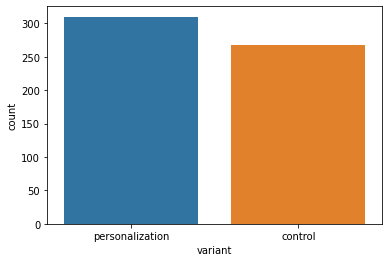

In [11]:
sns.countplot(x = 'variant', data = raw_data)

## Variant vs Converted

In [12]:
def prop_agg(df, y, x):
  temp_df = df.groupby([y,x], as_index = False).size()
  temp_df['prop'] = temp_df['size'] / temp_df.groupby(y)['size'].transform('sum')
  return temp_df

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


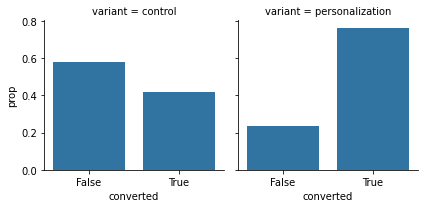

In [13]:
g = sns.FacetGrid(
    data = prop_agg(raw_data, "variant", "converted"),
    col = "variant"
)
g.map(sns.barplot, "converted", "prop");

We can observe that total conversion of B is greater than A. It seems that there's significant effect of variant B compared to A, but need to prove it to statistical test.

## Variant vs Revenue

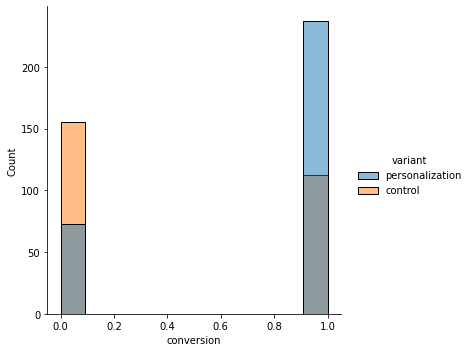

In [17]:
sns.displot(hue = 'variant', x = 'conversion', data = raw_data);

Seems that the revenue not normally distributed. It's better to remove outlier from the data.

In [18]:
raw_data.query('conversion > 0 & conversion < 1').groupby('variant').agg({'conversion': 'mean'})

,conversion
variant,


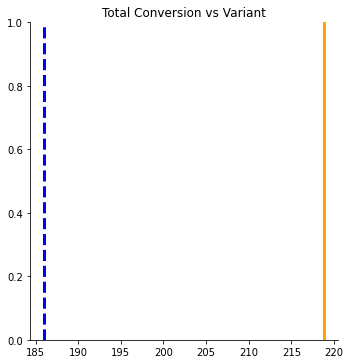

In [19]:
sns.displot(
    hue = 'variant', 
    x = 'conversion',
    bins = 6,
    data = raw_data.query('conversion > 0 & conversion < 1'),
    multiple="stack"
)
# add plot title
plt.title("Total Conversion vs Variant")
# add vertical line for mean of variant A
plt.axvline(186.000526, color = 'blue', linestyle = 'dashed', linewidth = 3)
# add vertical line for mean of variant B
plt.axvline(218.774444, color = 'orange', linewidth = 3)

In [23]:
sns.boxplot(
    x = 'variant', 
    y = 'conversion', 
    data = raw_data.query('conversion > 0 & conversion < 1'), min([], default="EMPTY"
).set_title("Total Conversion vs Variant")

SyntaxError: ignored

We can observe that there is difference of spending between variant group. Though the significance of difference need to be assess by statistical test.


## Using Proportion Test (Chi-Square) for Count Data


Calculate conversion for each variant

In [24]:
conv_calculation = raw_data.groupby(
    ['variant', 'converted'], as_index = False
).size().pivot(
    index='variant', columns = "converted", values = "size"
).reset_index().assign(
    conv_percent = lambda x: x[True] * 100 / (x[True] + x[False])
).assign(
    total_sample = lambda x: x[True] + x[False]
)

Check calculation result

In [25]:
conv_calculation

converted,variant,False,True,conv_percent,total_sample
0,control,155,112,41.947566,267
1,personalization,73,237,76.451613,310


Calculate uplift of B

In [26]:
conv_A = conv_calculation[conv_calculation['variant'] == 'A']['conv_percent'].values
conv_B = conv_calculation[conv_calculation['variant'] == 'B']['conv_percent'].values

In [27]:
(conv_B - conv_A)*100/conv_A

array([], dtype=float64)

We see there are 82% uplift of B compared to A

Do chi-squared test

In [28]:
# find number of succession
success = conv_calculation[['total_sample', True]].values[:,1]
# find number of all observations
obs = conv_calculation[['total_sample', True]].values[:,0]

In [29]:
result = proportions_chisquare(success, obs)

In [30]:
# Calculate chi squared result
print('X-squared: %.3f' % result[0])
print('p-value: %.3f' % result[1])

X-squared: 71.454
p-value: 0.000


**Interpretation**

- Variant A has 20 conversions compared to variant B has 37
- Relative uplift of B (5.07%) from A (2.77%) around 82.72%
- p-value computed is 0.02448 < 0.05, hence there is strong statistical significance in test results. Then, we should reject null hypothesis and proceed to launch variant B for all users


## Using Proportion Test (t-test) for Numerical Data


In [31]:
var_A = raw_data.query('revenue > 0 & revenue < 400 & variant == "A"')['revenue']
var_B = raw_data.query('revenue > 0 & revenue < 400 & variant == "B"')['revenue']

UndefinedVariableError: ignored

In [32]:
def f_test(group1, group2):
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = group1.size-1
    dun = group2.size-1
    p_value = 1-scipy.stats.f.cdf(f, nun, dun)
    return f, p_value
  
# perform F-test
f_test(var_A, var_B)

NameError: ignored

Because p-value = 0.191 > alpha = 0.05, hence there is no difference of variance between group. Then we can do t-test.

In [ ]:
ttest_ind(var_A, var_B, usevar='pooled')

Because p-value = 0.2353 > alpha = 0.05, hence there is no difference of revenue between group. Then we can conclude that variant B has no significant impact compared to variant A.

# Using Linear Models

## Using Logistic Regression for Binary Data


We can use logistic regression when the value to compare is categorical.

In [ ]:
# select variant and converted columns
data_for_model = raw_data[['variant', 'converted']].copy()
# create dummy variables and remove first category ('variant_A')
data_for_model = pd.get_dummies(data_for_model, drop_first = True)
# add constant
data_for_model = sm.add_constant(data_for_model)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# check the first 5 rows
data_for_model.head()

,const,converted,variant_B
0,1.0,False,0
1,1.0,False,0
2,1.0,False,0
3,1.0,False,0
4,1.0,False,0


In [ ]:
# define and fit logistic regression model
log_reg = sm.Logit(data_for_model['converted'], data_for_model[['variant_B','const']]).fit()

Optimization terminated successfully.
         Current function value: 0.163889
         Iterations 8


In [ ]:
# check model summary
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                 1451
Model:                          Logit   Df Residuals:                     1449
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 May 2022   Pseudo R-squ.:                 0.01069
Time:                        00:27:33   Log-Likelihood:                -237.80
converged:                       True   LL-Null:                       -240.37
Covariance Type:            nonrobust   LLR p-value:                   0.02340
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
variant_B      0.6267      0.283      2.217      0.027       0.073       1.181
const         -3.5568      0.227    -15.684      0.000      -4.001      -3.112
==============================================================================
"""

**Interpretation**

- We can observe uplift of variant B around 62.67%
- Based on p-value = 0.027 < alpha = 0.05, hence there is strong statistical significance in test results. Then, we should reject null hypothesis and proceed to launch variant B for all users


## Using Linear Regression for Numeric Data


We can use linear regression when the value to compare is numeric.

In [ ]:
# select variant and converted columns
data_for_model = raw_data[['variant', 'revenue']].copy()
# create dummy variables and remove first category ('variant_A')
data_for_model = pd.get_dummies(data_for_model, drop_first = True)
# add constant
data_for_model = sm.add_constant(data_for_model)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# check the first 5 rows
data_for_model.head()

,const,revenue,variant_B
0,1.0,0.0,0
1,1.0,0.0,0
2,1.0,0.0,0
3,1.0,0.0,0
4,1.0,0.0,0


In [ ]:
# define and fit linear regression model
lin_reg = sm.OLS(data_for_model['revenue'], data_for_model[['variant_B','const']]).fit()

In [ ]:
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9877
Date:                Mon, 30 May 2022   Prob (F-statistic):              0.320
Time:                        00:27:33   Log-Likelihood:                -44859.
No. Observations:                1451   AIC:                         8.972e+04
Df Residuals:                    1449   BIC:                         8.973e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
variant_B   3.375e+11    3.4e+11      0.994      0.320   -3.29e+11       1e+12
const          9.1021   2.41e+11   3.78e-11      1.000   -4.73e+11    4.73e+11
==============================================================================
Omnibus:                     4219.798   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        126418087.515
Skew:                          38.014   Prob(JB):                         0.00
Kurtosis:                    1447.027   Cond. No.                         2.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation**

- We can observe the impact of variant B around 32.77 times compared to variant A
- But, based on p-value = 0.235 > alpha = 0.05, hence there is no statistical significance in test results. Then, we should accept null hypothesis.
